# [Angle closure Glaucoma Evaluation Challenge](https://age.grand-challenge.org/Details/)
## Scleral spur localization Baseline （RCNN)

- To keep model training stable, images with coordinate == -1, were removed.

- For real inference, you MIGHT keep all images in val_file_path file.

In [1]:
import sys
sys.path.append('PaddleDetection')

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from paddle import fluid

from ppdet.core.workspace import load_config, create
from ppdet.modeling.model_input import create_feed
from ppdet.data.data_feed import create_reader

from ppdet.utils.eval_utils import parse_fetches
import ppdet.utils.checkpoint as checkpoint

from ppdet.utils.colormap import colormap

%matplotlib inline

docstring_parser is not installed, argument description is not available


In [3]:
import logging
FORMAT = '%(asctime)s-%(levelname)s: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT)
logger = logging.getLogger(__name__)

In [4]:
config_path = "./PaddleDetection/configs/cascade_rcnn_r50_fpn_1x.yml"
weight_path = "./PaddleDetection/output/cascade_rcnn_r50_fpn_1x/model_final"
infer_dir = "./PaddleDetection/dataset/coco/val2017"
origin_data_dir = "./PaddleDetection/dataset/coco/ASOCT_Image"
output_file = "./Localization_Results.csv"

data_root_path = "../datasets/Training100/"
label_file_path = os.path.join(data_root_path, "train_loc.csv")

In [5]:
def get_test_images(infer_dir, infer_img):
    """
    Get image path list in TEST mode
    """
    assert infer_img is not None or infer_dir is not None, \
        "--infer_img or --infer_dir should be set"
    assert infer_img is None or os.path.isfile(infer_img), \
            "{} is not a file".format(infer_img)
    assert infer_dir is None or os.path.isdir(infer_dir), \
            "{} is not a directory".format(infer_dir)
    images = []

    # infer_img has a higher priority
    if infer_img and os.path.isfile(infer_img):
        images.append(infer_img)
        return images

    infer_dir = os.path.abspath(infer_dir)
    assert os.path.isdir(infer_dir), \
        "infer_dir {} is not a directory".format(infer_dir)
    exts = ['jpg', 'jpeg', 'png', 'bmp']
    exts += [ext.upper() for ext in exts]
    for ext in exts:
        images.extend(glob.glob('{}/*.{}'.format(infer_dir, ext)))

    assert len(images) > 0, "no image found in {}".format(infer_dir)
    print("Found {} inference images in total.".format(len(images)))

    return images

In [6]:
cfg = load_config(config_path)

if 'architecture' in cfg:
    main_arch = cfg.architecture
else:
    raise ValueError("'architecture' not specified in config file.")

if 'test_feed' not in cfg:
    test_feed = create(main_arch + 'TestFeed')
else:
    test_feed = create(cfg.test_feed)

In [7]:
test_images = get_test_images(infer_dir, infer_img=None)
test_feed.dataset.add_images(test_images)

place = fluid.CUDAPlace(0) if cfg.use_gpu else fluid.CPUPlace()
exe = fluid.Executor(place)

model = create(main_arch)

startup_prog = fluid.Program()
infer_prog = fluid.Program()
with fluid.program_guard(infer_prog, startup_prog):
    with fluid.unique_name.guard():
        _, feed_vars = create_feed(test_feed, use_pyreader=False)
        test_fetches = model.test(feed_vars)
infer_prog = infer_prog.clone(True)

reader = create_reader(test_feed)
feeder = fluid.DataFeeder(place=place, feed_list=feed_vars.values())

exe.run(startup_prog)
checkpoint.load_checkpoint(exe, infer_prog, weight_path)

Found 608 inference images in total.


2019-08-06 17:06:46,169-INFO: Loading checkpoint from ./PaddleDetection/output/cascade_rcnn_r50_fpn_1x/model_final...


In [8]:
# parse infer fetches
assert cfg.metric in ['COCO', 'VOC'], \
        "unknown metric type {}".format(cfg.metric)
extra_keys = []
if cfg['metric'] == 'COCO':
    extra_keys = ['im_info', 'im_id', 'im_shape']
if cfg['metric'] == 'VOC':
    extra_keys = ['im_id']
keys, values, _ = parse_fetches(test_fetches, infer_prog, extra_keys)

# parse dataset category
if cfg.metric == 'COCO':
    from ppdet.utils.coco_eval import bbox2out, mask2out, get_category_info
if cfg.metric == "VOC":
    from ppdet.utils.voc_eval import bbox2out, get_category_info

anno_file = getattr(test_feed.dataset, 'annotation', None)
with_background = getattr(test_feed, 'with_background', True)
use_default_label = getattr(test_feed, 'use_default_label', False)
clsid2catid, catid2name = get_category_info(anno_file, with_background,
                                            use_default_label)

# whether output bbox is normalized in model output layer
is_bbox_normalized = False
if hasattr(model, 'is_bbox_normalized') and \
        callable(model.is_bbox_normalized):
    is_bbox_normalized = model.is_bbox_normalized()


2019-08-06 17:06:46,316-INFO: Not found annotation file dataset/coco/annotations/instances_val2017.json, load coco17 categories.


In [9]:
def draw_bbox(image, im_id, catid2name, bboxes, threshold, is_bbox_normalized=False):
    catid2color = {}
    color_list = colormap(rgb=True)[:40]

    for dt in np.array(bboxes):
        if im_id != dt['image_id']:
            continue
        catid, bbox, score = dt['category_id'], dt['bbox'], dt['score']
        if score < threshold:
            continue

        xmin, ymin, w, h = bbox
        if is_bbox_normalized:
            im_width, im_height = image.size
            xmin *= im_width
            ymin *= im_height
            w *= im_width
            h *= im_height
        xmax = xmin + w
        ymax = ymin + h

        if catid not in catid2color:
            idx = np.random.randint(len(color_list))
            catid2color[catid] = color_list[idx]
        color = tuple(map(lambda x:int(x*255), catid2color[catid]))
        xmin, ymin, xmax, ymax = int(xmin),int(ymin), int(xmax),int(ymax)

        # draw bbox
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color,10)
        # draw label
        text = "{} {:.2f}".format(catid2name[catid], score)
        cv2.putText(image,text,(xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 2,color,5, cv2.LINE_AA)
    return image
    
def calc_box(image, im_id, bboxes, threshold, is_bbox_normalized=False):
    best_box = []
    best_score = 0.
    for dt in np.array(bboxes):
        if im_id != dt['image_id']:
            continue
        catid, bbox, score = dt['category_id'], dt['bbox'], dt['score']
        if score < threshold:
            continue

        xmin, ymin, w, h = bbox
        if is_bbox_normalized:
            im_width, im_height = image.size
            xmin *= im_width
            ymin *= im_height
            w *= im_width
            h *= im_height
        xmax = xmin + w
        ymax = ymin + h

        xmin, ymin, xmax, ymax = int(xmin),int(ymin), int(xmax),int(ymax)
        
        if best_score < score:
            best_score = score
            best_box = (xmin, ymin, xmax, ymax)

    return best_box

### Save File

In [10]:
imid2path = reader.imid2path
result = {}
for iter_id, data in enumerate(reader()):
    outs = exe.run(infer_prog,
                   feed=feeder.feed(data),
                   fetch_list=values,
                   return_numpy=False)
    res = {
        k: (np.array(v), v.recursive_sequence_lengths())
        for k, v in zip(keys, outs)
    }

    bbox_results = bbox2out([res], clsid2catid, is_bbox_normalized)

    im_ids = res['im_id'][0]
    for im_id in im_ids:
        image_path = imid2path[int(im_id)]
        image = cv2.imread(image_path)[:,:,::-1]

        box = calc_box(image, int(im_id), bbox_results, 0.1, is_bbox_normalized)

        file_name = image_path.split("/")[-1].split("_")[0]
        point = ((box[2] + box[0]) / 2, (box[3] + box[1]) / 2)
        
        if file_name not in result.keys():
            result[file_name] = [[-1, -1], [-1, -1]]
        if "left" in image_path: result[file_name][0] = point
        else: 
            image = cv2.imread(os.path.join(origin_data_dir, file_name+".jpg"))
            nrows, ncols, ch = image.shape
            result[file_name][1] = [(ncols - nrows) + point[0], point[1]]


In [11]:
with open(output_file, "w+") as f:
    f.write("{},{},{},{},{}\n".format("ASOCT_NAME", "X_LEFT", "Y_LEFT", "X_RIGHT", "Y_RIGHT"))
    for file, pred_point in result.items():
        f.write("{},{},{},{},{}\n".format(file+".jpg", *pred_point[0], *pred_point[1]))

### Result Visualization

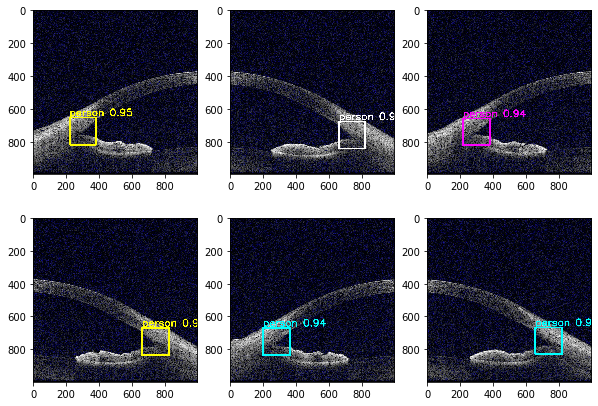

In [13]:
imid2path = reader.imid2path
plt.figure(figsize=(10, 7))
for iter_id, data in enumerate(reader()):
    outs = exe.run(infer_prog,
                   feed=feeder.feed(data),
                   fetch_list=values,
                   return_numpy=False)
    res = {
        k: (np.array(v), v.recursive_sequence_lengths())
        for k, v in zip(keys, outs)
    }

    bbox_results = bbox2out([res], clsid2catid, is_bbox_normalized)

    # visualize result
    im_ids = res['im_id'][0]
    image_path = imid2path[int(im_ids[0])]
    image = cv2.imread(image_path)[:,:,::-1]
    image = draw_bbox(image.copy(), int(im_ids[0]), 
                        catid2name, bbox_results, 0.5, is_bbox_normalized)
    plt.subplot(2,3,iter_id+1)
    plt.imshow(image)
    if iter_id > 4: break

### Distance Evaluating

In [14]:
result_csv = pd.read_csv(output_file).merge(
        pd.read_csv(label_file_path), left_on="ASOCT_NAME", right_on="ASOCT_Name", 
        how='left'
    )

In [15]:
result_csv["x1_dis"] = result_csv.apply(
    func=lambda x:np.sqrt((x['X1']-x['X_LEFT'])**2 + (x['Y1']-x['Y_LEFT'])**2),
    axis=1
    )
result_csv
result_csv["x2_dis"] = result_csv.apply(
    func=lambda x:np.sqrt((x['X2']-x['X_RIGHT'])**2 + (x['Y2']-x['Y_RIGHT'])**2),
    axis=1
    )

In [16]:
dis = np.concatenate([result_csv['x1_dis'].values, result_csv['x2_dis'].values], axis=0)
dis.shape

(608,)

In [17]:
print("Minimum Distance: {:.2f}, idx: {}".format(dis.min(), dis.argmin()))
print("Maximum Distance: {:.2f}, idx: {}".format(dis.max(), dis.argmax()))
print("Average Distance: {:.2f}".format(dis.mean()))

Minimum Distance: 0.37, idx: 511
Maximum Distance: 63.47, idx: 469
Average Distance: 14.28


Text(0, 0.5, 'Number')

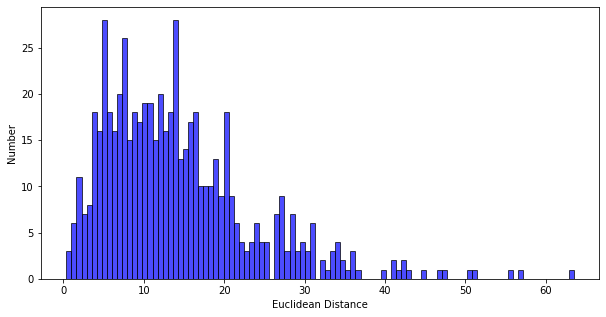

In [18]:
plt.figure(figsize=(10,5))
_ = plt.hist(dis, bins=100, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Euclidean Distance")
plt.ylabel("Number")